# Drift Speed Evaluation
* This notebook is used to generate results for the different drift speed of the RBF dataset

## Imports

In [ ]:
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
from utilities.configs import *
config_1 = get_config_for_dataset('rbf_m')

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config_1['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config_1['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
import time

tf.random.set_seed(config_1['computation']['random_seed'])
np.random.seed(config_1['computation']['random_seed'])
random.seed(config_1['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config_1['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-21--08-52-54823508


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Run Evaluation

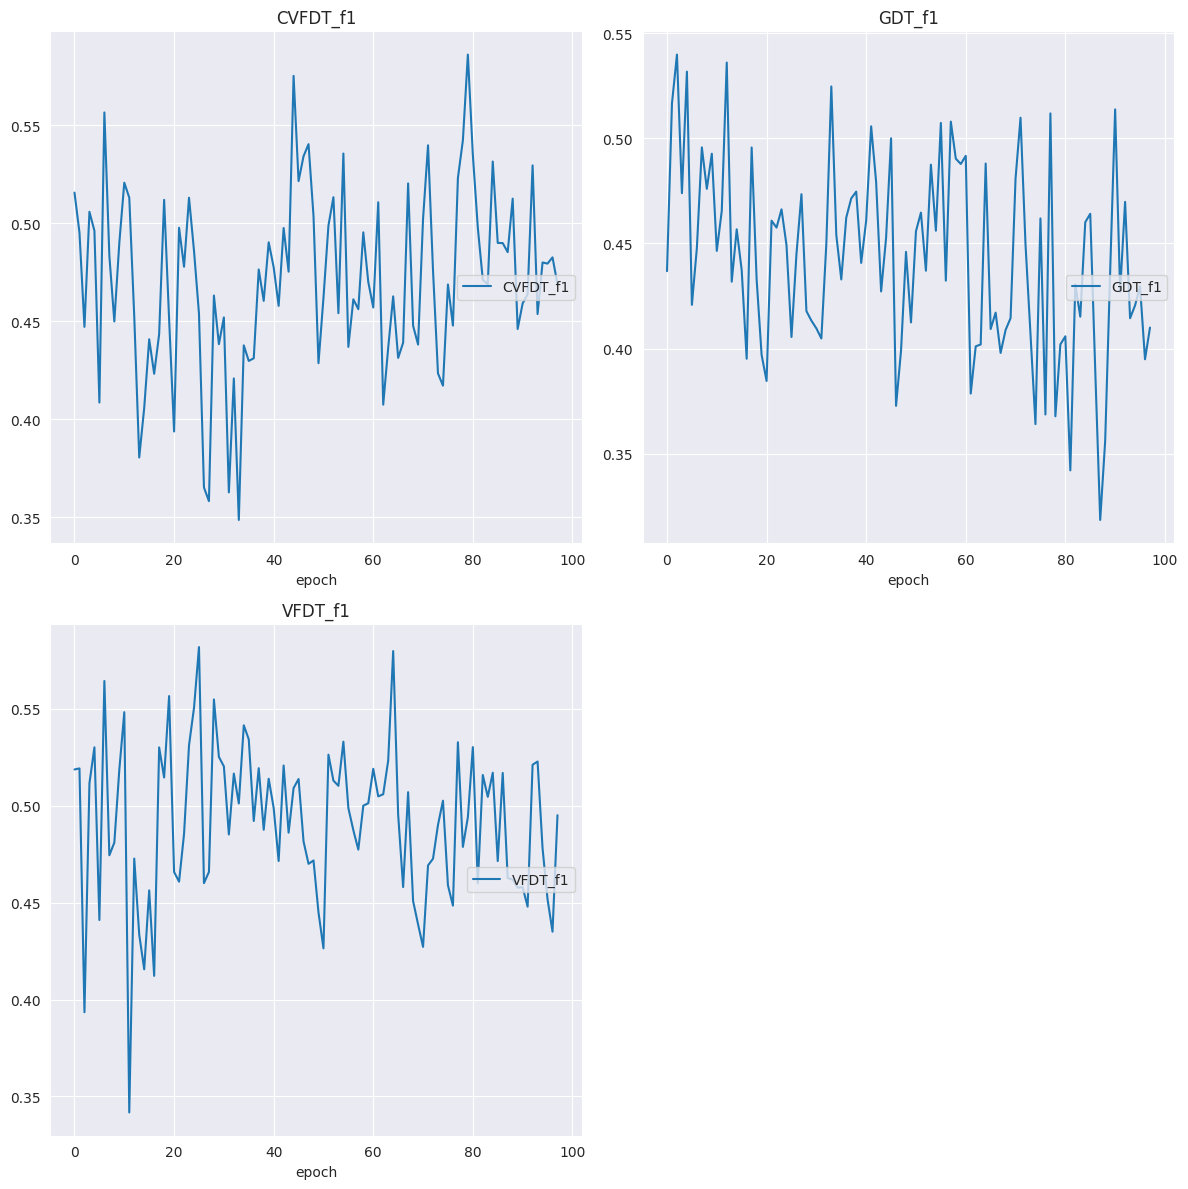

CVFDT_f1
	CVFDT_f1         	 (min:    0.349, max:    0.586, cur:    0.469)
GDT_f1
	GDT_f1           	 (min:    0.319, max:    0.540, cur:    0.410)
VFDT_f1
	VFDT_f1          	 (min:    0.342, max:    0.582, cur:    0.495)


In [6]:
from sklearn.metrics import cohen_kappa_score
#'NOAA_Weather','agr_a','agr_g','airlines','electricity','hyperplane','rbf_f','rbf_m','sea_a','sea_g'
dataset_names = ['rbf_1,5']
for dataset_name in dataset_names:
    config = get_config_for_dataset('rbf_f')#dataset_name

    VFDT_classifier = HoeffdingTreeClassifier()
    CVFDT_classifier = HoeffdingAdaptiveTreeClassifier()

    config_training, metrics = prepare_training_for_streams(identifier = 'BIN:'+dataset_name, config = config)
    #load Dataset
    X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:'+dataset_name, 
                                                                              max_total_samples = config['computation']['max_total_samples'])

    model_dict = {}
    scores_dict = {}
    normalizer_list = []
    plotlosses_benchmark = PlotLosses()
    verbosity = 1
    model_dict['GDT'] = GDT(number_of_variables = len(X_data.columns),
                number_of_classes = len(np.unique(y_data)),#dataset_dict['number_of_classes'],

                objective = config_training['gdt']['objective'],

                depth = config_training['gdt']['depth'],

                learning_rate_index = config_training['gdt']['learning_rate_index'],
                learning_rate_values = config_training['gdt']['learning_rate_values'],
                learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

                optimizer = config_training['gdt']['optimizer'],

                loss = 'crossentropy',

                initializer_values = config_training['gdt']['initializer_values'],
                initializer_index = config_training['gdt']['initializer_index'],
                initializer_leaf = config_training['gdt']['initializer_leaf'],        

                random_seed = config_training['computation']['random_seed'],
                verbosity = verbosity)  


    #Pretraing
    if(config_training['computation']['pretrain_size']>0 and len(X_data) > config_training['computation']['pretrain_size']):
        X_pretrain_data = X_data.iloc[:config_training['computation']['pretrain_size'],:]
        X_data = X_data.iloc[config_training['computation']['pretrain_size']:,:]
        y_pretrain_data = y_data.iloc[:config_training['computation']['pretrain_size']]
        y_data = y_data.iloc[config_training['computation']['pretrain_size']:]

        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_pretrain_data, 
                                           y_pretrain_data,
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               }



        model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],
                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['pretrain_epochs'], 
                  restarts = 0,#config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 
                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],
                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))

        #pretrain benchmarks
        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values
        for i in range(0, len(dataset_dict['X_train'])):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64)) 
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))






    #prepare Stream
    X_data_stream = split_df_chunks(X_data, config['computation']['chunk_size'])
    y_data_stream = split_df_chunks(y_data, config['computation']['chunk_size'])

    scores_GDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    scores_VFDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    scores_CVFDT = {'f1':np.array([]),
                  'acc':np.array([]),
                  'kappa':np.array([])
                 }
    timer = {'training':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             },
             'prediction':{
                'GDT':0.0,
                'VFDT':0.0,
                'CVFDT':0.0,
             }
            }
    flag = False;

    #Start Stream
    for i in range(len(X_data_stream)):
        normalizer_list=[]
        ((X_train, y_train),
         (X_valid, y_valid),
         (X_test, y_test),
         (X_train_with_valid, y_train_with_valid),
         normalizer_list) = preprocess_data(X_data_stream[i], 
                                           y_data_stream[i],
                                           nominal_features,
                                           ordinal_features,
                                           config_training,
                                           normalizer_list,
                                           random_seed= 42,#random_seed,
                                           verbosity=1)#verbosity)  
        dataset_dict = {
               'X_train': X_train,
               'y_train': y_train,
               'X_valid': X_valid,
               'y_valid': y_valid,
               'X_test': X_test,
               'y_test': y_test,
               'normalizer_list': normalizer_list
               }  


        t0 = time.time()
        #if(i==491):
        #    flag = True
        history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
                  dataset_dict['y_train'],

                  batch_size=config_training['gdt']['batch_size'], 
                  epochs=config_training['gdt']['epochs'], 

                  restarts = 0,
                  drift_flag = flag,
                  #config_test['gdt']['restarts'], 
                  #restart_type=config_test['gdt']['restart_type'], 

                  #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
                  #early_stopping_type=config_test['gdt']['early_stopping_type'],

                  valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
        flag=False
        t1 = time.time()
        timer['training']['GDT'] = timer['training']['GDT']+t1-t0


        ###EVALUATION
        y_test_data = dataset_dict['y_test'].values
        temp_X_test = dataset_dict['X_test'].values

        temp_X_train =X_train_with_valid.values
        temp_y_train =y_train_with_valid.values


        t0 = time.time()
        #GDT
        metric = "f1"
        y_test_data = dataset_dict['y_test']
        y_pred_GDT = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
        y_pred_GDT = np.nan_to_num(y_pred_GDT)
        y_pred_GDT = np.round(y_pred_GDT)
        #GDT_f1 = sklearn.metrics.get_scorer(metric)._score_func(y_pred_GDT, y_test, average='weighted')
        GDT_f1 = f1_score(y_test_data, y_pred_GDT)
        GDT_acc = accuracy_score(y_test_data, y_pred_GDT)
        GDT_kappa = cohen_kappa_score(y_test_data,y_pred_GDT)

        t1 = time.time()
        timer['prediction']['GDT'] = timer['prediction']['GDT']+t1-t0


        #VFDT
        t0 = time.time()
        y_pred_VFDT = []
        for i in range(0, len(temp_X_train)):
            VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
        t1 = time.time()
        timer['training']['VFDT'] = timer['training']['VFDT']+t1-t0

        t0 = time.time()
        for i in range(0, len(dataset_dict['X_test'])):
            y_pred_VFDT.append(VFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        VFDT_f1 = f1_score(y_test_data, y_pred_VFDT)
        VFDT_acc = accuracy_score(y_test_data, y_pred_VFDT)
        VFDT_kappa = cohen_kappa_score(y_test_data,y_pred_VFDT)
        t1 = time.time()
        timer['prediction']['VFDT'] = timer['prediction']['VFDT']+t1-t0

        #CVFDT
        t0 = time.time()
        y_pred_CVFDT = []
        for i in range(0, len(dataset_dict['X_train'])):
            CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
        t1 = time.time()
        timer['training']['CVFDT'] = timer['training']['CVFDT']+t1-t0

        t0 = time.time()
        for i in range(0, len(dataset_dict['X_test'])):
            y_pred_CVFDT.append(CVFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
        CVFDT_f1 = f1_score(y_test_data, y_pred_CVFDT)
        CVFDT_acc = accuracy_score(y_test_data, y_pred_CVFDT)
        CVFDT_kappa = cohen_kappa_score(y_test_data,y_pred_CVFDT)
        t1 = time.time()
        timer['prediction']['CVFDT'] = timer['prediction']['CVFDT']+t1-t0



        plotlosses_benchmark.update({'GDT_f1': GDT_f1,'VFDT_f1': VFDT_f1, 'CVFDT_f1':CVFDT_f1})
        plotlosses_benchmark.send() 


        scores_GDT['f1'] = np.append(scores_GDT['f1'], GDT_f1)
        scores_VFDT['f1'] = np.append(scores_VFDT['f1'], VFDT_f1)
        scores_CVFDT['f1'] = np.append(scores_CVFDT['f1'], CVFDT_f1)

        scores_GDT['acc'] = np.append(scores_GDT['acc'], GDT_acc)
        scores_VFDT['acc'] = np.append(scores_VFDT['acc'], VFDT_acc)
        scores_CVFDT['acc'] = np.append(scores_CVFDT['acc'], CVFDT_acc)

        scores_GDT['kappa'] = np.append(scores_GDT['kappa'], GDT_kappa)
        scores_VFDT['kappa'] = np.append(scores_VFDT['kappa'], VFDT_kappa)
        scores_CVFDT['kappa'] = np.append(scores_CVFDT['kappa'], CVFDT_kappa)


    #save_scores(dataset_name, scores_GDT, scores_VFDT, scores_CVFDT, VFDT_classifier, CVFDT_classifier, config, timer)
    results = pd.DataFrame(columns=['Metric','Dataset', 'GDT', 'VFDT', 'CVFDT'])
    results.loc[len(results)] =['Kappa',dataset_name,round(np.mean(scores_GDT['kappa']),4),round(np.mean(scores_VFDT['kappa']),4),round(np.mean(scores_CVFDT['kappa']),4)]
    results.to_csv('results/rbf_speed/'+dataset_name+'.csv')